# Please check from the LSTM implementation

In [246]:
# import necessary libraries
import pandas as pd
import os
import glob
import datetime as dt
from datetime import datetime 
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
#import pandas_datareader as webreader # Remote data access for pandas

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
from numpy import array
import pandas as pd # Additional functions for analysing and manipulating data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
# Import Libraries and packages from Keras
from tensorflow.keras.optimizers import Adam
plt.style.use('fivethirtyeight')

In [3]:
path = os.getcwd()
txt_files = glob.glob(os.path.join(path, "/Users/dinesh/Documents/Data Science/ASX-2015-2018_orig", "*.txt"))

In [4]:
# use glob to get all the csv files 
# in the folder
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.DataFrame()
  
# loop over the list of csv files
for f in txt_files:
      
    # read the csv file
    current_df = pd.read_csv(f, header=None)
    #pd.read_csv(io.StringIO(t), names=['Date','AgentName','Group','Direction'], skiprows=1,)
    df = df.append(current_df,ignore_index=True)
      
df.columns = ["Ticker", "Date", "Open", "High", "Low", "Close", "Volume"]
df['Date']=pd.to_datetime(df['Date'], format='%Y%m%d')
df.head()  

,Ticker,Date,Open,High,Low,Close,Volume
0,1AL,2016-01-21,1.030,1.030,1.030,1.030,3000
1,1PG,2016-01-21,3.150,3.150,2.850,3.040,505502
2,3DM,2016-01-21,0.076,0.076,0.075,0.075,59659
3,3PL,2016-01-21,1.430,1.530,1.355,1.520,646143
4,4DS,2016-01-21,0.034,0.034,0.033,0.033,330000


In [247]:
df_table = pd.pivot_table(df, values='Close', index=['Date'], columns=['Ticker'])
df_table.head()

Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYL,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,1.215,NaN,NaN,NaN,2.26,NaN,NaN,...,NaN,NaN,NaN,NaN,0.067,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,1.265,NaN,NaN,NaN,2.07,NaN,NaN,...,NaN,NaN,4.40,NaN,0.070,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,1.245,NaN,NaN,NaN,2.08,NaN,NaN,...,NaN,NaN,4.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,1.250,NaN,NaN,NaN,2.05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,1.255,NaN,NaN,NaN,2.08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# we could fill NaN here but some of the timeseries data stated late hence bigining NaN is not actual NaN, 
#hence we will handle Nan Individually

In [399]:
## lets select tickers that starts on 2015-01-02
## get index of column with first value not NaN

row_1=df_table.iloc[0]
non_nan_col = []
for idx, value in row_1.items():
    if not pd.isnull(value):#include all columns
        non_nan_col.append(str(idx))
df_stat = df_table[non_nan_col]

In [400]:
#Checking weather the data is stationary or not. If we use ARIMA model it can automatically handle non-stationary datas.
# we check the P value for each column and if P value is > 0.05 we accept the null hypothesis that the timeseries has unit root, 
#i.e, time series is stationary

from statsmodels.tsa.stattools import adfuller
arima_models = {}

for i in range(0, 20):#df_stat.shape[1]):
    
    # get column name for the ticker
    col_name = df_stat.columns[i]
    #col_name = 'QBE'    
    # get data for the Ticker
    df_model = df[df.Ticker == col_name]
    df_model = df_model[["Date", "Close"]]
    df.sort_values(by=['Date'], inplace=True)
    
    df.dropna(thresh=2, axis=1)
    # if the ticker has less than 6 months of data we exit
    #if len(df_model) <180:
    #   continue
        
    df_model = df_model.set_index("Date")
    
    
    #impute missing value as previous known value 
    df_model = df_model.fillna(method="ffill")

        
    # remove leading and trailing nan from the timeseries and they might be missing due to late indexing of Ticker
    #col_data = col_data.loc[col_data.first_valid_index():col_data.last_valid_index()]
    df_model = df_model.dropna()
     
    
    # check is timeseries is stationary or not
    result = adfuller(df_model["Close"].values, autolag='AIC')
    t_stat, p_value, _, _, critical_values, _  = adfuller(df_model["Close"].values, autolag='AIC')

    print('Ticker {} has p-value of {} and is {}'.format(col_name, p_value, "Non-Stationary" if p_value > 0.05 else "Stationary"))
    
   

Ticker 1PG has p-value of 0.7319626396749548 and is Non-Stationary
Ticker 3PL has p-value of 0.6376996600344458 and is Non-Stationary
Ticker 8IH has p-value of 0.7630886856014671 and is Non-Stationary
Ticker AAA has p-value of 0.09458643681284085 and is Non-Stationary
Ticker AAC has p-value of 0.4494964443671214 and is Non-Stationary
Ticker AAD has p-value of 0.009011968153376175 and is Stationary
Ticker AAX has p-value of 0.05001816077713417 and is Non-Stationary
Ticker ABC has p-value of 0.6826596433102917 and is Non-Stationary
Ticker ABL has p-value of 0.2679094985100683 and is Non-Stationary
Ticker ABP has p-value of 0.49977452557283625 and is Non-Stationary
Ticker ABU has p-value of 0.18789043616696544 and is Non-Stationary
Ticker ABV has p-value of 0.8818159679014651 and is Non-Stationary
Ticker ABX has p-value of 0.3384243501127042 and is Non-Stationary
Ticker ABY has p-value of 0.9944193853976988 and is Non-Stationary
Ticker ACB has p-value of 0.17209750674271335 and is Non-Sta

# Multivariate LSTM implementation (deep neural network). I have implemented for Ticker QBE. This process can be automized  as mentioned in the previous source code.

In [401]:
for i in range(0, 1):#df_stat.shape[1]):
    
    # get column name for the ticker
    #col_name = df_stat.columns[i]
    col_name = 'QBE'    
    # get data for the Ticker
    df_model1 = df[df.Ticker == col_name]
    df_model1 = df_model1[["Date", "Close", 'Open', 'High', 'Low', 'Volume']]
    df_model1.sort_values(by=['Date'], inplace=True)
    
    # if the ticker has less than 6 months of data we exit
    #if len(df_model1) < 180:
        #continue
        
    #df_model1 = df_model1.set_index("Date")
    
    
    #impute missing value as previous known value 
    df_model1 = df_model1.fillna(method="ffill")

        
    # remove leading and trailing nan from the timeseries and they might be missing due to late indexing of Ticker
    #col_data = col_data.loc[col_data.first_valid_index():col_data.last_valid_index()]
    df_model1 = df_model1.dropna()

In [402]:
##creating more features to feed to the neural network
#Close return
df_model1["cr"] = df_model1["Close"].div(df_model1["Close"].shift(1))
df_model1["cr"]= df_model1["cr"]-1

#Future close return
df_model1["fcr"] = df_model1["Close"].shift(-1).div(df_model1["Close"])
df_model1["fcr"]= df_model1["fcr"]-1



df_model1 = df_model1.fillna(df_model1.mean())

<ipython-input-402-8422ba51add1>:12: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_model1 = df_model1.fillna(df_model1.mean())


#Simple demonstration on feature engineering
#Creating more features

In [403]:
#creating more features
df_model1["last_week_average"] = df_model1["Close"].rolling(7).mean()
df_model1["last_week_max"] = df_model1["Close"].rolling(7).max()
df_model1["last_week_min"] = df_model1["Close"].rolling(7).min()
#df_model["cr"] = df_model["Close"].diff(periods=1)
df_model1["t1"] = df_model1["Close"].shift(1)
df_model1["t2"] = df_model1["Close"].shift(2)
df_model1["t3"] = df_model1["Close"].shift(3)
df_model1["t4"] = df_model1["Close"].shift(4)
df_model1["t5"] = df_model1["Close"].shift(5)
df_model1["t6"] = df_model1["Close"].shift(6)
df_model1["t7"] = df_model1["Close"].shift(7)
df_model1["t8"] = df_model1["Close"].shift(8)
df_model1["t9"] = df_model1["Close"].shift(9)
#df_model["fcr"]= df_model["Close"].pct_change(fill_method ='ffill')
df_model1["last_week_day_change"] = df_model1["cr"].shift(7)

#df_model.reset_index(inplace=True)
#df_model1 = df_model1.dropna()
df_model1 = df_model1.fillna(df_model1.mean())
f_model1 = df_model1.dropna()


<ipython-input-403-06db9a64f373>:20: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_model1 = df_model1.fillna(df_model1.mean())


# Multivariate LSTM implementation for prediction

# All the provided models were used to demonstated the result. The result seems file but can be improvsed more. I have used one value 'Close' from a Ticker and showed the prediction from antoehr 90 days. We can create many features as shown below by doing the feature engineering. Userfull feature will produce more accurate results. 

In [404]:
#create features
df_model1["last_week_average"] = df_model1["Close"].rolling(7).mean()
df_model1["last_week_max"] = df_model1["Close"].rolling(7).max()
df_model1["last_week_min"] = df_model1["Close"].rolling(7).min()
#df_model["cr"] = df_model["Close"].diff(periods=1)
df_model1["t1"] = df_model1["Close"].shift(1)
df_model1["t2"] = df_model1["Close"].shift(2)
df_model1["t3"] = df_model1["Close"].shift(3)
df_model1["t4"] = df_model1["Close"].shift(4)
df_model1["t5"] = df_model1["Close"].shift(5)
df_model1["t6"] = df_model1["Close"].shift(6)
df_model1["t7"] = df_model1["Close"].shift(7)
df_model1["t8"] = df_model1["Close"].shift(8)
df_model1["t9"] = df_model1["Close"].shift(9)
#df_model["fcr"]= df_model["Close"].pct_change(fill_method ='ffill')
df_model1["last_week_day_change"] = df_model1["cr"].shift(7)

#df_model.reset_index(inplace=True)
#df_model1 = df_model1.dropna()
df_model1 = df_model1.fillna(df_model1.mean())
f_model1 = df_model1.dropna()


<ipython-input-404-b3bde68f15e1>:20: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_model1 = df_model1.fillna(df_model1.mean())


In [405]:
#Separate dates for future plotting

train_dates = pd.to_datetime(df_model1['Date'])
print(train_dates.tail(15)) #Check last few dates. 

1272267   2018-06-08
134084    2018-06-12
124984    2018-06-13
309146    2018-06-14
304302    2018-06-15
1036463   2018-06-18
1034727   2018-06-19
1278300   2018-06-20
1281452   2018-06-21
1195156   2018-06-22
1028591   2018-06-25
1118220   2018-06-26
1127211   2018-06-27
312373    2018-06-28
301023    2018-06-29
Name: Date, dtype: datetime64[ns]


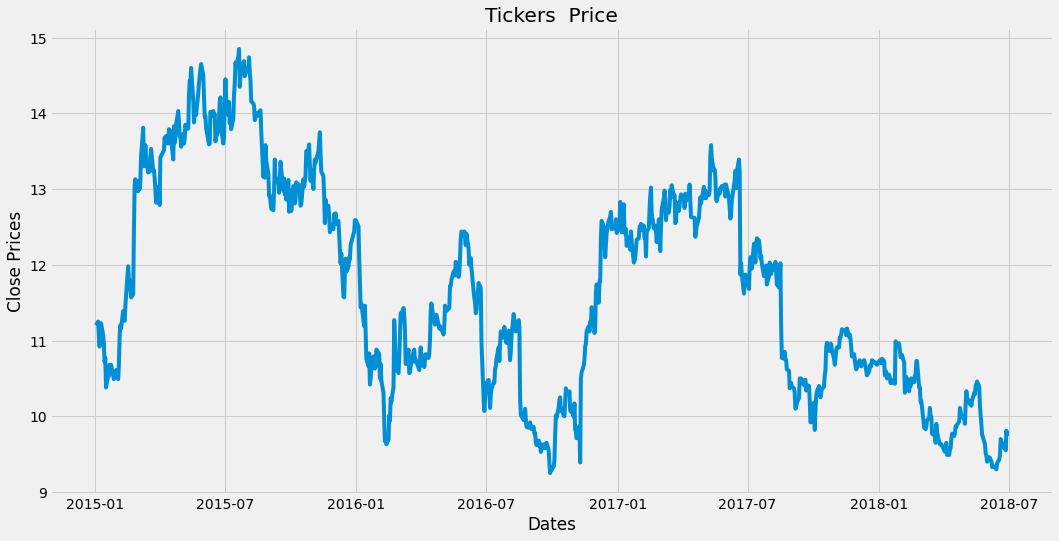

In [406]:
#Visualize the per day closing price of the stock.
#plot close price
df_model2 = df_model1.set_index(['Date'])
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df_model2['Close'])
plt.title('Tickers  Price')
plt.show()

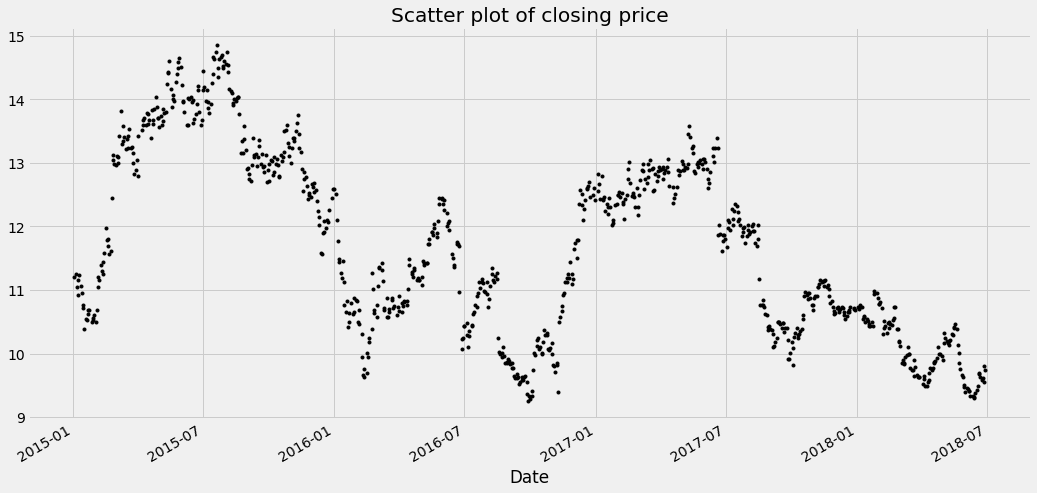

In [407]:
#Lets us plot the scatterplot:
plt.figure(figsize=(16,8))
df_close = df_model2['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

In [408]:
#Variables for training
cols = list(df_model1)[1:]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Close', 'Open', 'High', 'Low', 'Volume', 'cr', 'fcr', 'last_week_average', 'last_week_max', 'last_week_min', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 'last_week_day_change']


In [409]:
#New dataframe with only training data - 5 columns
df_for_training = df_model1[cols]

In [410]:
df_for_training.head()

,Close,Open,High,Low,Volume,cr,fcr,last_week_average,last_week_max,last_week_min,t1,t2,t3,t4,t5,t6,t7,t8,t9,last_week_day_change
703239,11.20,11.19,11.24,11.03,1402171,-0.000028,0.004464,11.678712,11.925952,11.432338,11.67229,11.674404,11.676818,11.679158,11.681549,11.683877,11.686164,11.688434,11.69095,-0.000034
855295,11.25,11.15,11.38,11.10,2589538,0.004464,-0.017778,11.678712,11.925952,11.432338,11.20000,11.674404,11.676818,11.679158,11.681549,11.683877,11.686164,11.688434,11.69095,-0.000034
935980,11.05,11.10,11.16,10.97,3798144,-0.017778,-0.011765,11.678712,11.925952,11.432338,11.25000,11.200000,11.676818,11.679158,11.681549,11.683877,11.686164,11.688434,11.69095,-0.000034
946194,10.92,11.00,11.00,10.84,3868958,-0.011765,0.021062,11.678712,11.925952,11.432338,11.05000,11.250000,11.200000,11.679158,11.681549,11.683877,11.686164,11.688434,11.69095,-0.000034
463411,11.15,11.00,11.19,10.93,5025248,0.021062,0.007175,11.678712,11.925952,11.432338,10.92000,11.050000,11.250000,11.200000,11.681549,11.683877,11.686164,11.688434,11.69095,-0.000034


In [411]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#scaler  = MinMaxScaler(feature_range= (0,1))
#scaled_data = scaler.fit_transform(df_for_training)
#scaled_data


In [412]:
df_for_training_scaled.shape

(883, 20)

In [413]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 120  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (763, 120, 20).
trainY shape == (763, 1).


In [414]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

#model = Sequential()
#model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(32, activation='relu', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(trainY.shape[1]))


#Build the LSTM model
model  =Sequential()
model.add(LSTM(50,return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 120, 50)           14200     
_________________________________________________________________
lstm_24 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_22 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 26        
Total params: 35,701
Trainable params: 35,701
Non-trainable params: 0
_________________________________________________________________


In [415]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
43/43 [==============================] - 8s 116ms/step - loss: 0.1102 - val_loss: 0.0102
Epoch 2/5
43/43 [==============================] - 3s 81ms/step - loss: 0.0172 - val_loss: 0.0030
Epoch 3/5
43/43 [==============================] - 4s 82ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 4/5
43/43 [==============================] - 4s 86ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 5/5
43/43 [==============================] - 4s 82ms/step - loss: 0.0057 - val_loss: 0.0013


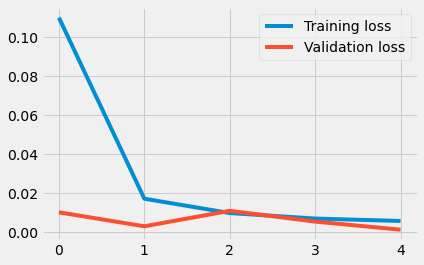

In [416]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [417]:
from business_duration import businessDuration
import pandas as pd
from datetime import time,datetime
import holidays as pyholidays
from pandas.tseries.holiday import (
    Holiday, AbstractHolidayCalendar, next_monday,
    MO, TU, FR, next_monday_or_tuesday,
    GoodFriday, EasterMonday)
from pandas.tseries.offsets import CustomBusinessDay

In [418]:

aus_bd = CustomBusinessDay(calendar=AbstractHolidayCalendar())

In [419]:
n_past = 16
n_days_for_prediction=90 

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=aus_bd).tolist()
print(predict_period_dates)


[Timestamp('2018-06-07 00:00:00', freq='C'), Timestamp('2018-06-08 00:00:00', freq='C'), Timestamp('2018-06-11 00:00:00', freq='C'), Timestamp('2018-06-12 00:00:00', freq='C'), Timestamp('2018-06-13 00:00:00', freq='C'), Timestamp('2018-06-14 00:00:00', freq='C'), Timestamp('2018-06-15 00:00:00', freq='C'), Timestamp('2018-06-18 00:00:00', freq='C'), Timestamp('2018-06-19 00:00:00', freq='C'), Timestamp('2018-06-20 00:00:00', freq='C'), Timestamp('2018-06-21 00:00:00', freq='C'), Timestamp('2018-06-22 00:00:00', freq='C'), Timestamp('2018-06-25 00:00:00', freq='C'), Timestamp('2018-06-26 00:00:00', freq='C'), Timestamp('2018-06-27 00:00:00', freq='C'), Timestamp('2018-06-28 00:00:00', freq='C'), Timestamp('2018-06-29 00:00:00', freq='C'), Timestamp('2018-07-02 00:00:00', freq='C'), Timestamp('2018-07-03 00:00:00', freq='C'), Timestamp('2018-07-04 00:00:00', freq='C'), Timestamp('2018-07-05 00:00:00', freq='C'), Timestamp('2018-07-06 00:00:00', freq='C'), Timestamp('2018-07-09 00:00:00'

In [420]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

In [421]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


<ipython-input-422-5bbad243b1a8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

<AxesSubplot:xlabel='Date', ylabel='Close'>

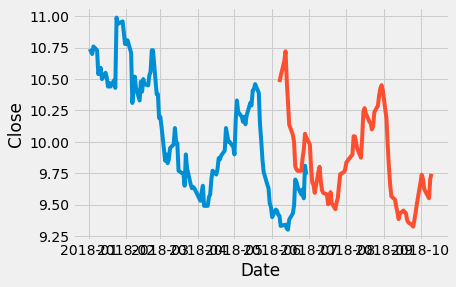

In [422]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df_model1[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2018-1-1']

sns.lineplot(original['Date'], original['Close'])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])